# LTV Market Score Model with KNN Imputation for Multiple Missing Features

In [1]:
# 1. Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
# 2. Load and Merge Datasets
df = pd.read_csv('zip_code_market_tracker.tsv000', sep='\t')
df['PERIOD_BEGIN'] = pd.to_datetime(df['PERIOD_BEGIN'])
df['ZIP'] = df['REGION'].str.extract(r'Zip Code: (\d{5})')
df = df[df['PERIOD_BEGIN'] == df['PERIOD_BEGIN'].max()]

metro_la = ['Los Angeles, CA', 'Orange County, CA', 'Ventura, CA', 'Riverside, CA', 'San Bernardino, CA']
df = df[df['PARENT_METRO_REGION'].isin(metro_la)]

income = pd.read_csv('ACSDT5Y2023.B06011-Data.csv')
income['ZIP'] = income['GEO_ID'].str.extract(r'(\d{5})$')
income = income.rename(columns={'B06011_001E': 'Median_Income'})[['ZIP', 'Median_Income']]
df = df.merge(income, on='ZIP', how='left')

In [3]:
# 2a. Clean and Apply KNN Imputation for All Key Variables
df_knn = df.copy()
# Convert invalid values to NaN
cols_to_numeric = ['HOMES_SOLD', 'MEDIAN_DOM', 'AVG_SALE_TO_LIST', 'Median_Income']
for col in cols_to_numeric:
    df_knn[col] = pd.to_numeric(df_knn[col], errors='coerce')
# Encode categorical variable
le = LabelEncoder()
df_knn['PARENT_METRO_REGION_ENC'] = le.fit_transform(df_knn['PARENT_METRO_REGION'])
# Define and apply KNN imputer
knn_features = ['PARENT_METRO_REGION_ENC', 'HOMES_SOLD', 'MEDIAN_DOM', 'AVG_SALE_TO_LIST', 'Median_Income']
imputer = KNNImputer(n_neighbors=3)
df_knn[knn_features] = imputer.fit_transform(df_knn[knn_features])
# Restore imputed values
df[['HOMES_SOLD', 'MEDIAN_DOM', 'AVG_SALE_TO_LIST', 'Median_Income']] = df_knn[['HOMES_SOLD', 'MEDIAN_DOM', 'AVG_SALE_TO_LIST', 'Median_Income']]

In [4]:
# 3. Market Score Calculation
df['score_sale_to_list'] = df['AVG_SALE_TO_LIST'].rank(pct=True)
df['score_homes_sold'] = df['HOMES_SOLD'].rank(pct=True)
df['score_dom'] = 1 - df['MEDIAN_DOM'].rank(pct=True)
df['score_income'] = df['Median_Income'].rank(pct=True)

df['market_score'] = 100 * (
    0.35 * df['score_sale_to_list'] +
    0.35 * df['score_homes_sold'] +
    0.15 * df['score_dom'] +
    0.15 * df['score_income']
)

In [5]:
# 5. Classify and Adjust LTV
def classify_market(score):
    if score >= 70:
        return 'Prime'
    elif score <= 35:
        return 'Declining'
    return 'Neutral'

df['market_category'] = df['market_score'].apply(classify_market)

In [6]:
# 6. Apply LTV Adjustment Framework
county_adj = {
    'Los Angeles, CA': -2,
    'Orange County, CA': 0,
    'Ventura, CA': -1,
    'Riverside, CA': -1,
    'San Bernardino, CA': -1
}
score_adj = {'Prime': 2, 'Declining': -5, 'Neutral': 0}

df['county_adj'] = df['PARENT_METRO_REGION'].map(county_adj)
df['score_adj'] = df['market_category'].map(score_adj)

df['base_ltv'] = 70
df['max_ltv'] = df['base_ltv'] + df['county_adj'] + df['score_adj']
df['max_ltv'] = df['max_ltv'].clip(60, 75)

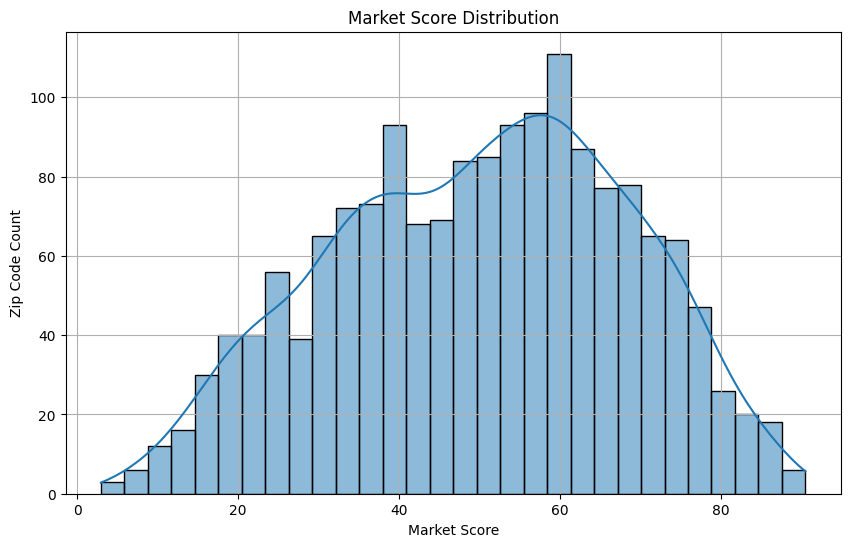

In [7]:
# 7. Market Score Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['market_score'], bins = 30, kde = True)
plt.title('Market Score Distribution')
plt.xlabel('Market Score')
plt.ylabel('Zip Code Count')
plt.grid(True)
plt.savefig("Market_Score_Distribution.pdf", format="pdf")
plt.show()

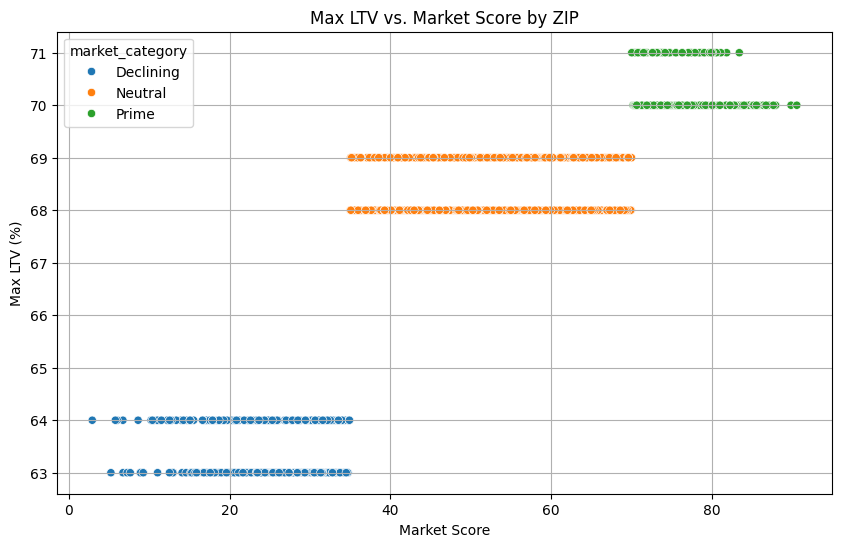

In [8]:
# Max LTV vs Market Score Scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='market_score', y='max_ltv', hue='market_category')
plt.title('Max LTV vs. Market Score by ZIP')
plt.xlabel('Market Score')
plt.ylabel('Max LTV (%)')
plt.grid(True)
plt.savefig("Max_LTV_vs_Market_Score_by_ZIP.pdf", format="pdf")
plt.show()

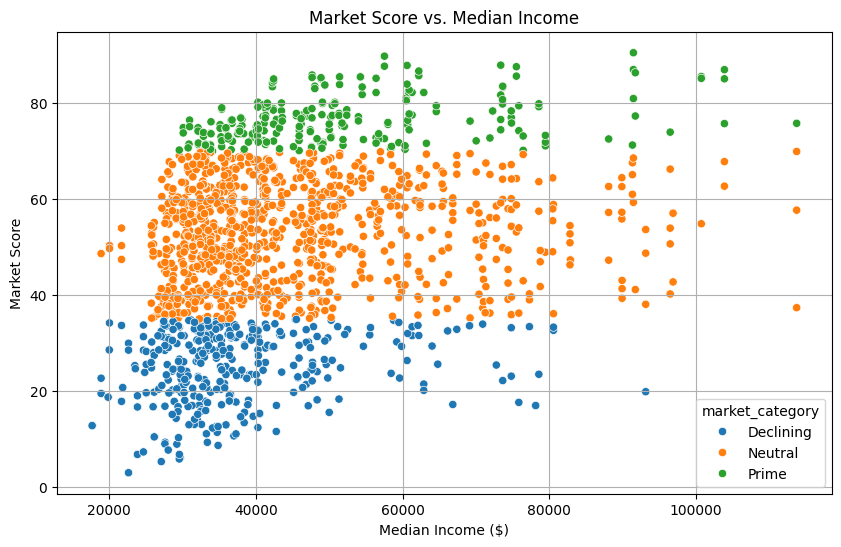

In [9]:
# Median Income vs. Market Score Scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Median_Income', y='market_score', hue='market_category')
plt.title('Market Score vs. Median Income')
plt.xlabel('Median Income ($)')
plt.ylabel('Market Score')
plt.grid(True)
plt.savefig("Market_Score_vs_Median_Income.pdf", format="pdf")
plt.show()

In [10]:
# 8. Top/Bottom 10 Zip Codes
top10 = df.sort_values('market_score', ascending=False).head(10)
bottom10 = df.sort_values('market_score').head(10)
display(top10[['ZIP', 'market_score', 'max_ltv', 'market_category', 'Median_Income']])
display(bottom10[['ZIP', 'market_score', 'max_ltv', 'market_category', 'Median_Income']])

,ZIP,market_score,max_ltv,market_category,Median_Income
1405,91105,90.538438,70,Prime,91447.0
1091,91107,89.820012,70,Prime,57509.0
240,91030,87.945394,70,Prime,73363.0
402,90066,87.888957,70,Prime,60593.0
140,91107,87.724222,70,Prime,57509.0
1063,90405,87.618975,70,Prime,75495.0
84,91105,87.021049,70,Prime,91447.0
811,90266,87.002746,70,Prime,103855.0
1264,91214,86.714460,70,Prime,62194.0
476,90402,86.362111,70,Prime,91710.0


,ZIP,market_score,max_ltv,market_category,Median_Income
510,92225,2.919463,64,Declining,22621.0
755,90057,5.239475,63,Declining,27087.0
924,92301,5.793167,64,Declining,29543.0
56,92240,6.018914,64,Declining,29665.0
0,92254,6.732764,64,Declining,23840.0
1227,91204,6.738865,63,Declining,29555.0
1359,90011,7.260525,63,Declining,24657.0
1420,90270,7.652532,63,Declining,28035.0
1284,92333,8.621110,64,Declining,34834.0
749,90304,8.881940,63,Declining,29213.0


In [11]:
# 9. Export Results to a .csv File
summary = df[['ZIP', 'PARENT_METRO_REGION', 'market_score', 'market_category', 'Median_Income',
              'county_adj', 'score_adj', 'max_ltv', 'MEDIAN_SALE_PRICE', 'HOMES_SOLD', 'MEDIAN_DOM']]
summary.to_csv('Metro_LA_LTV_Scores.csv', index=False)
summary.head()

,ZIP,PARENT_METRO_REGION,market_score,market_category,Median_Income,county_adj,score_adj,max_ltv,MEDIAN_SALE_PRICE,HOMES_SOLD,MEDIAN_DOM
0,92254,"Riverside, CA",6.732764,Declining,23840.0,-1,-5,64,320000.0,1.0,77.0
1,92508,"Riverside, CA",64.234289,Neutral,54421.0,-1,0,69,730000.0,86.0,48.0
2,90277,"Los Angeles, CA",63.630262,Neutral,78560.0,-2,0,68,985000.0,15.0,26.5
3,91790,"Los Angeles, CA",56.696156,Neutral,36732.0,-2,0,68,787521.0,7.0,24.0
4,92252,"Riverside, CA",35.546065,Neutral,29443.0,-1,0,69,401750.0,64.0,114.0
